# KE5105 - Building Electrical Consumption Forecasting

# Modelling 5 - Preliminary model

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
import platform
GPUs = GPU.getGPUs()
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
 print("# of CPU: {0}".format(psutil.cpu_count()))
 print("CPU type: {0}".format(platform.uname()))
printm()

  Running setup.py bdist_wheel for gputil ... - done
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.5 GB  | Proc size: 694.0 MB
GPU RAM Free: 11325MB | Used: 116MB | Util   1% | Total 11441MB
# of CPU: 2
CPU type: uname_result(system='Linux', node='96cfd4985142', release='4.14.79+', version='#1 SMP Wed Dec 19 21:19:13 PST 2018', machine='x86_64', processor='x86_64')


In [0]:
# from google.colab import files
# files.upload()

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
!ls -l /content/gdrive/My\ Drive/python

total 18263
-rw------- 1 root root 10291100 Jan  3 03:28 AS5.csv
-rw------- 1 root root    14384 Jan  9 09:36 base-3x64gru-nomask-val-history.pkl
-rw------- 1 root root  2857160 Jan 14 09:52 base-4x128gru-1x32dense-dropout.h5
-rw------- 1 root root     2604 Jan 14 09:52 base-4x128gru-1x32dense-dropout-history.pkl
-rw------- 1 root root  2857264 Jan 14 06:41 base-4x128gru-1x32dense-nomask-val.h5
-rw------- 1 root root    14384 Jan 14 06:41 base-4x128gru-1x32dense-nomask-val-history.pkl
-rw------- 1 root root   754824 Jan 11 09:09 base-4x64gru-1x32dense-nomask-val.h5
-rw------- 1 root root    14384 Jan 11 09:09 base-4x64gru-1x32dense-nomask-val-history.pkl
-rw------- 1 root root   733624 Jan 10 09:35 base-4x64gru-nomask-val.h5
-rw------- 1 root root    14384 Jan 10 09:35 base-4x64gru-nomask-val-history.pkl
-rw------- 1 root root    42400 Jan  4 05:53 base-rnn-nomask-16x16-val.h5
-rw------- 1 root root   324496 Jan  8 06:12 base-rnn-nomask-2x64-val.h5
-rw------- 1 root root    47136 Jan  

In [0]:
!cp /content/gdrive/My\ Drive/python/myUtilities.py ./

## Load libraries

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
import os
import pickle
import pandas as pd
import numpy as np
import datetime
import myUtilities as mu
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

Using TensorFlow backend.


## Load data for building AS5

In [0]:
as5 = mu.load_data_by_bldg(['AS5'], 'processed')

In [9]:
as5[0][1].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62880 entries, 2015-06-01 00:00:00 to 2018-12-31 23:30:00
Data columns (total 17 columns):
PWMMainIC                         46164 non-null float64
PWMEXTAS4ExBldg                   46165 non-null float64
PWMAS4LanguageCenter              46165 non-null float64
PWMCANTEEN                        46164 non-null float64
PWMStreetLight                    46164 non-null float64
BTUAS5                            46175 non-null float64
PWMMainIC_30min_avg               46117 non-null float64
PWMEXTAS4ExBldg_30min_avg         46118 non-null float64
PWMAS4LanguageCenter_30min_avg    46118 non-null float64
PWMCANTEEN_30min_avg              46117 non-null float64
PWMStreetLight_30min_avg          46117 non-null float64
BTUAS5_30min_avg                  46129 non-null float64
PWM_sumadd                        46117 non-null float64
PWM_sumsubtract                   46117 non-null float64
PWM_30min_avg                     46117 non-null float64
B

## Split the data into train and test set

In [0]:
as5_train_df = as5[0][1].loc['2015-06-12 08:00:00':'2017-03-31 23:30:00', :]

In [11]:
as5_train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31616 entries, 2015-06-12 08:00:00 to 2017-03-31 23:30:00
Data columns (total 17 columns):
PWMMainIC                         30018 non-null float64
PWMEXTAS4ExBldg                   30018 non-null float64
PWMAS4LanguageCenter              30018 non-null float64
PWMCANTEEN                        30018 non-null float64
PWMStreetLight                    30018 non-null float64
BTUAS5                            30029 non-null float64
PWMMainIC_30min_avg               29985 non-null float64
PWMEXTAS4ExBldg_30min_avg         29985 non-null float64
PWMAS4LanguageCenter_30min_avg    29985 non-null float64
PWMCANTEEN_30min_avg              29985 non-null float64
PWMStreetLight_30min_avg          29985 non-null float64
BTUAS5_30min_avg                  29998 non-null float64
PWM_sumadd                        29985 non-null float64
PWM_sumsubtract                   29985 non-null float64
PWM_30min_avg                     29985 non-null float64
B

In [0]:
as5_test_df = as5[0][1].loc['2018-01-01 00:00:00':, :]

In [13]:
as5_test_df.index.max()

Timestamp('2018-12-31 23:30:00')

In [14]:
as5_test_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17520 entries, 2018-01-01 00:00:00 to 2018-12-31 23:30:00
Data columns (total 17 columns):
PWMMainIC                         16145 non-null float64
PWMEXTAS4ExBldg                   16145 non-null float64
PWMAS4LanguageCenter              16145 non-null float64
PWMCANTEEN                        16145 non-null float64
PWMStreetLight                    16145 non-null float64
BTUAS5                            16144 non-null float64
PWMMainIC_30min_avg               16132 non-null float64
PWMEXTAS4ExBldg_30min_avg         16132 non-null float64
PWMAS4LanguageCenter_30min_avg    16132 non-null float64
PWMCANTEEN_30min_avg              16132 non-null float64
PWMStreetLight_30min_avg          16132 non-null float64
BTUAS5_30min_avg                  16130 non-null float64
PWM_sumadd                        16132 non-null float64
PWM_sumsubtract                   16132 non-null float64
PWM_30min_avg                     16132 non-null float64
B

## Parameters for the RNN model

Also used for generating the datasets with the lagged values 

In [0]:
lookback = 240  # 5 days; each day has 48 observations
step = 1  # sampling rate used for the lookback period
delay = 0  # 1 step ahead prediction
batch_size = 128

## Normalise the training data

* Convert PWM and BTU values into the range 0 to 1
* Replace NaN with -1

In [0]:
# Create a transformation pipleline to prepare the training dataset for RNN.
attrbs = ['PWM_30min_avg', 'BTU_30min_avg']
my_pipeline = Pipeline([
    ('selector', mu.DataFrameSelector(attrbs)),
    ('minmax_scaler', MinMaxScaler()),
    ('na_transform', mu.Nan_to_Num_Transformer())
])

In [17]:
as5_train_data = my_pipeline.fit_transform(as5_train_df)
as5_train_data

array([[ 0.26254935,  0.56924225],
       [ 0.26724948,  0.53427896],
       [ 0.28031585,  0.53353241],
       ...,
       [ 0.12897161,  0.03222595],
       [ 0.10312089,  0.00348389],
       [-1.        , -1.        ]])

## Split a validation set out from the train set

In [0]:
as5_train_split = as5_train_data[:20000]
as5_val_split = as5_train_data[20000:]

In [19]:
print('train split = %s\nvalidation split = %s' % (as5_train_split.shape, as5_val_split.shape))

train split = (20000, 2)
validation split = (11616, 2)


## Base RNN Model (4x64 GRU nodes, 1x32 dense nodes)

In [0]:
model = Sequential()
model.add(layers.GRU(64, return_sequences=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.GRU(64, return_sequences=True))
model.add(layers.GRU(64, return_sequences=True))
model.add(layers.GRU(64))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [0]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)

In [0]:
t1 = datetime.datetime.now()
history = model.fit_generator(generator=gen_train, epochs=120,
                              validation_data=gen_val,
                              workers=1, use_multiprocessing=True, shuffle=True)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Epoch 1/120
143/143 [==============================] - 202s 1s/step - loss: 0.0588 - mean_absolute_percentage_error: 38.8215 - val_loss: 0.0340 - val_mean_absolute_percentage_error: 14.9361
Epoch 2/120
143/143 [==============================] - 201s 1s/step - loss: 0.0369 - mean_absolute_percentage_error: 25.1968 - val_loss: 0.0364 - val_mean_absolute_percentage_error: 14.7982
Epoch 3/120
143/143 [==============================] - 200s 1s/step - loss: 0.0314 - mean_absolute_percentage_error: 21.6177 - val_loss: 0.0233 - val_mean_absolute_percentage_error: 15.0742
Epoch 4/120
143/143 [==============================] - 200s 1s/step - loss: 0.0292 - mean_absolute_percentage_error: 19.1806 - val_loss: 0.0313 - val_mean_absolute_percentage_error: 13.8736
Epoch 5/120
143/143 [==============================] - 200s 1s/step - loss: 0.0276 - mean_absolute_percentage_error: 18.6050 - val_loss: 0.0222 - val_mean_absolute_percentage_error: 13.7194
Epoch 6/120
143/143 [=============================

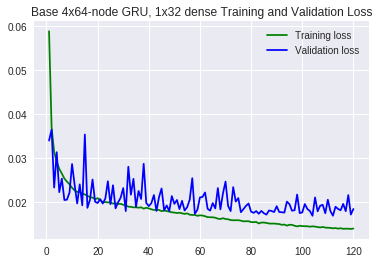

In [0]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.figure()
plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Base 4x64-node GRU, 1x32 dense Training and Validation Loss')
plt.legend()
plt.show()

In [0]:
print('Train MAE = %f\nValidation MAE = %f' % ((train_loss[-1] * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (val_loss[-1] * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 1.487985
Validation MAE = 1.960549


In [0]:
gen_pred = mu.DataGenerator(as5_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                            batch_size=batch_size, step=step)
as5_train_preds = model.predict_generator(gen_pred, workers=1, use_multiprocessing=True)
as5_train_preds.shape

(29754, 1)

In [0]:
as5_train_preds_withnan = np.full((as5_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_data)):
    if as5_train_data[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds[j]
        j += 1
as5_train_preds_withnan.shape

(31616, 1)

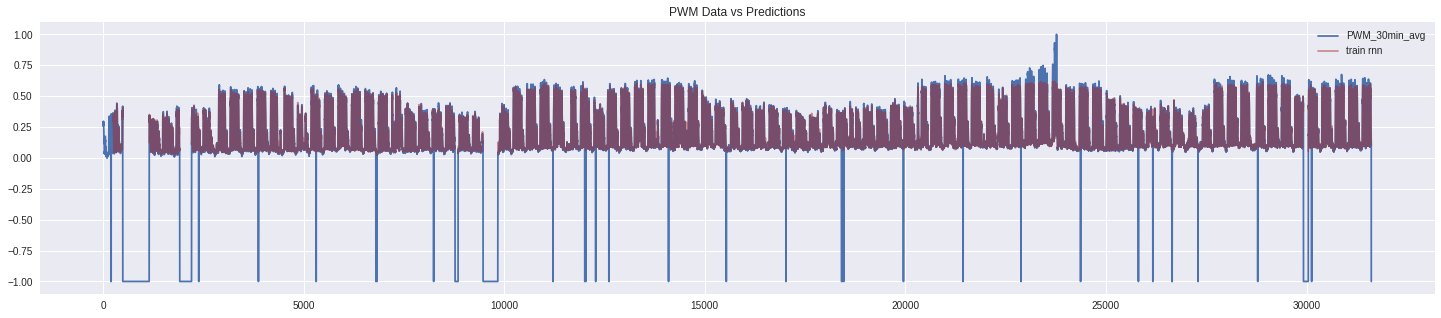

In [0]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(as5_train_data.shape[0]), as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

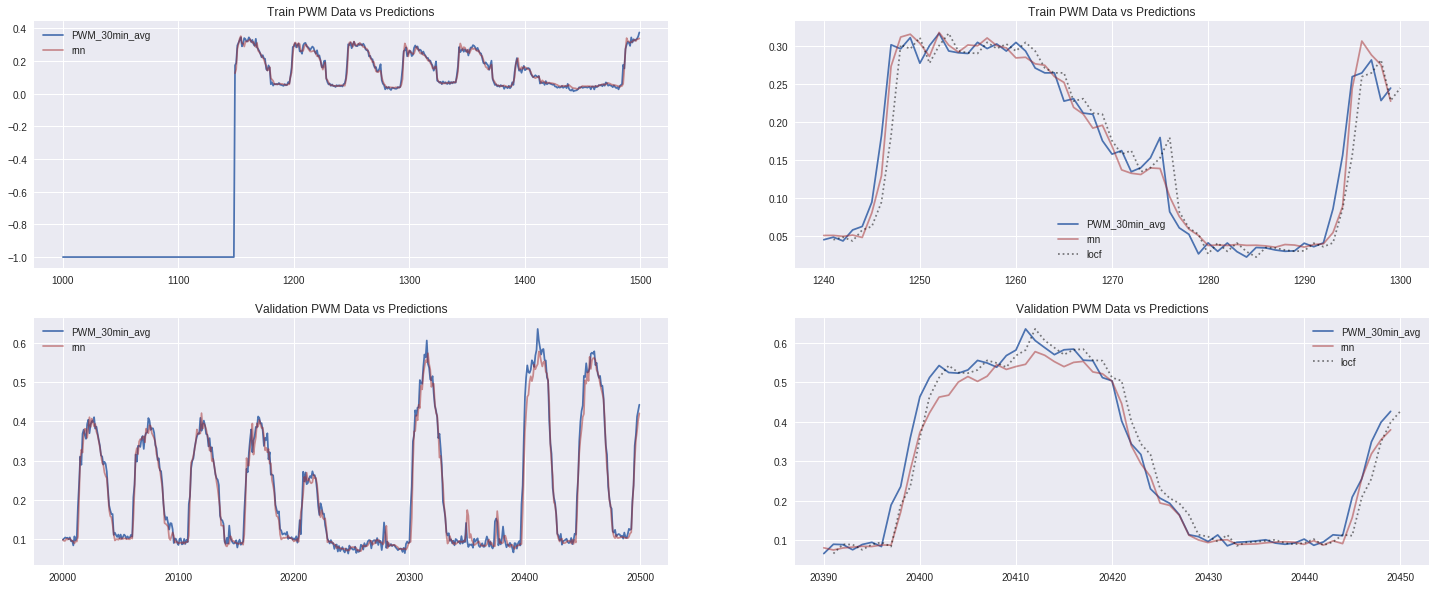

In [0]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(1000, 1500), as5_train_data[1000:1500, 0], label='PWM_30min_avg')
plt.plot(range(1000, 1500), as5_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1240, 1300), as5_train_data[1240:1300, 0], label='PWM_30min_avg')
plt.plot(range(1240, 1300), as5_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(1241, 1301), as5_train_data[1240:1300, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(20000, 20500), as5_train_data[20000:20500, 0], label='PWM_30min_avg')
plt.plot(range(20000, 20500), as5_train_preds_withnan[20000:20500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(20390, 20450), as5_train_data[20390:20450, 0], label='PWM_30min_avg')
plt.plot(range(20390, 20450), as5_train_preds_withnan[20390:20450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(20391, 20451), as5_train_data[20390:20450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [0]:
model.save('/content/gdrive/My Drive/python/base-4x64gru-1x32dense-nomask-val.h5')

In [0]:
with open('/content/gdrive/My Drive/python/base-4x64gru-1x32dense-nomask-val-history.pkl', 'wb') as outfile:
    pickle.dump(history.history, outfile)

## Base RNN Model (4x128 GRU, 1x32 Dense nodes)

In [0]:
model = Sequential()
model.add(layers.CuDNNGRU(128, return_sequences=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.CuDNNGRU(128, return_sequences=True))
model.add(layers.CuDNNGRU(128, return_sequences=True))
model.add(layers.CuDNNGRU(128))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [0]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)

In [0]:
t1 = datetime.datetime.now()
history = model.fit_generator(generator=gen_train, epochs=120,
                              validation_data=gen_val,
                              workers=1, use_multiprocessing=True, shuffle=True, verbose=2)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Epoch 1/120
 - 35s - loss: 0.0669 - mean_absolute_percentage_error: 43.8336 - val_loss: 0.0567 - val_mean_absolute_percentage_error: 29.8318
Epoch 2/120
 - 32s - loss: 0.0410 - mean_absolute_percentage_error: 27.8878 - val_loss: 0.0437 - val_mean_absolute_percentage_error: 28.5735
Epoch 3/120
 - 31s - loss: 0.0341 - mean_absolute_percentage_error: 24.1232 - val_loss: 0.0457 - val_mean_absolute_percentage_error: 19.0306
Epoch 4/120
 - 31s - loss: 0.0313 - mean_absolute_percentage_error: 21.1072 - val_loss: 0.0405 - val_mean_absolute_percentage_error: 15.0684
Epoch 5/120
 - 32s - loss: 0.0292 - mean_absolute_percentage_error: 19.7283 - val_loss: 0.0219 - val_mean_absolute_percentage_error: 13.4589
Epoch 6/120
 - 32s - loss: 0.0280 - mean_absolute_percentage_error: 19.5880 - val_loss: 0.0254 - val_mean_absolute_percentage_error: 14.3168
Epoch 7/120
 - 32s - loss: 0.0266 - mean_absolute_percentage_error: 18.2126 - val_loss: 0.0320 - val_mean_absolute_percentage_error: 13.0302
Epoch 8/120
 

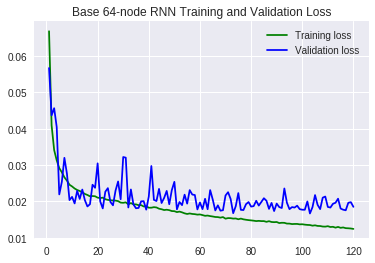

In [0]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.figure()
plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Base 64-node RNN Training and Validation Loss')
plt.legend()
plt.show()

In [0]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 1.320607
Validation MAE = 1.773322


In [0]:
gen_pred = mu.DataGenerator(as5_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                            batch_size=batch_size, step=step)
as5_train_preds = model.predict_generator(gen_pred, workers=1, use_multiprocessing=True)
as5_train_preds.shape

(29754, 1)

In [0]:
as5_train_preds_withnan = np.full((as5_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_data)):
    if as5_train_data[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds[j]
        j += 1
as5_train_preds_withnan.shape

(31616, 1)

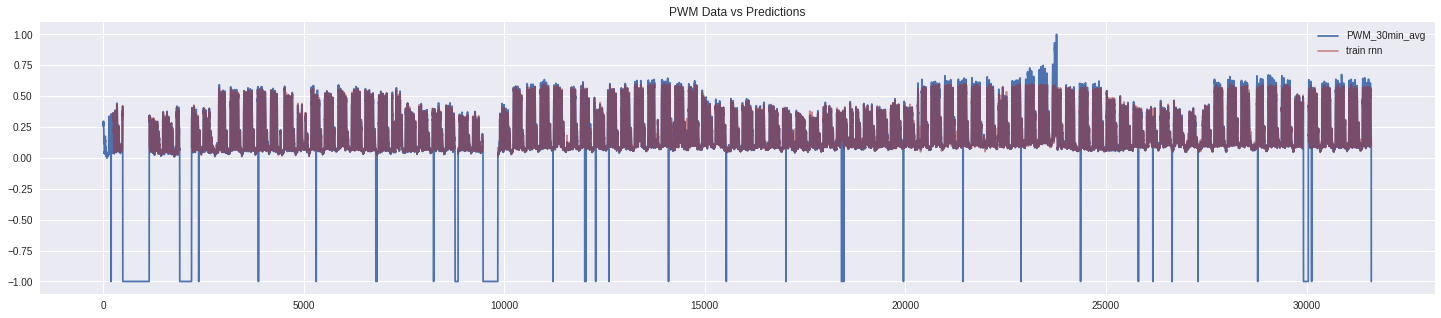

In [0]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(as5_train_data.shape[0]), as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

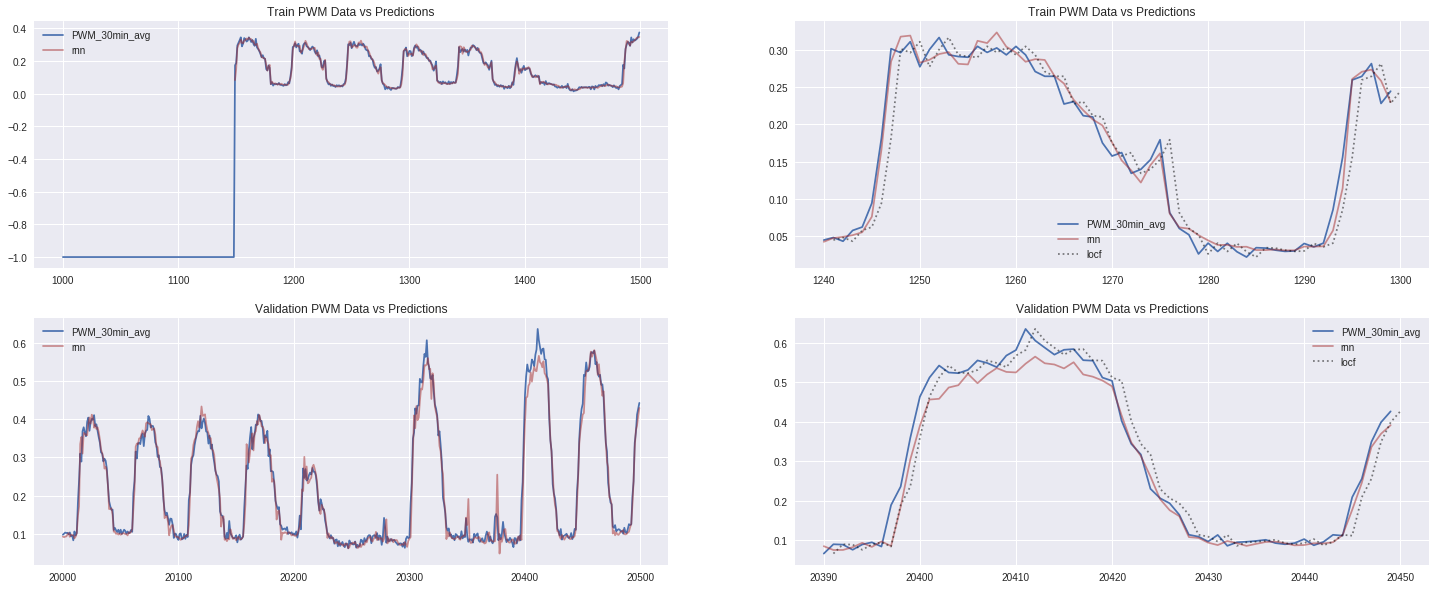

In [0]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(1000, 1500), as5_train_data[1000:1500, 0], label='PWM_30min_avg')
plt.plot(range(1000, 1500), as5_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1240, 1300), as5_train_data[1240:1300, 0], label='PWM_30min_avg')
plt.plot(range(1240, 1300), as5_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(1241, 1301), as5_train_data[1240:1300, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(20000, 20500), as5_train_data[20000:20500, 0], label='PWM_30min_avg')
plt.plot(range(20000, 20500), as5_train_preds_withnan[20000:20500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(20390, 20450), as5_train_data[20390:20450, 0], label='PWM_30min_avg')
plt.plot(range(20390, 20450), as5_train_preds_withnan[20390:20450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(20391, 20451), as5_train_data[20390:20450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [0]:
model.save('/content/gdrive/My Drive/python/base-4x128gru-1x32dense-nomask-val.h5')

In [0]:
with open('/content/gdrive/My Drive/python/base-4x128gru-1x32dense-nomask-val-history.pkl', 'wb') as outfile:
    pickle.dump(history.history, outfile)

## Base RNN Model (4x128 GRU, 1x32 Dense nodes) with regularisation

In [0]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [0]:
model = Sequential()
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.2, recurrent_dropout=0.2, return_sequences=True, reset_after=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.2, recurrent_dropout=0.2, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.2, recurrent_dropout=0.2, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.2, recurrent_dropout=0.2, reset_after=True))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [0]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)

In [0]:
t1 = datetime.datetime.now()
history = model.fit_generator(generator=gen_train, epochs=25,
                              validation_data=gen_val,
                              workers=2, use_multiprocessing=True, shuffle=True, verbose=2)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Epoch 1/25
 - 209s - loss: 0.0827 - mean_absolute_percentage_error: 49.6044 - val_loss: 0.0697 - val_mean_absolute_percentage_error: 42.2615
Epoch 2/25
 - 207s - loss: 0.0624 - mean_absolute_percentage_error: 37.2493 - val_loss: 0.0578 - val_mean_absolute_percentage_error: 21.1498
Epoch 3/25
 - 207s - loss: 0.0543 - mean_absolute_percentage_error: 34.0027 - val_loss: 0.0811 - val_mean_absolute_percentage_error: 26.1993
Epoch 4/25
 - 207s - loss: 0.0504 - mean_absolute_percentage_error: 30.3489 - val_loss: 0.0620 - val_mean_absolute_percentage_error: 27.8323
Epoch 5/25
 - 207s - loss: 0.0459 - mean_absolute_percentage_error: 28.2336 - val_loss: 0.0296 - val_mean_absolute_percentage_error: 17.2279
Epoch 6/25
 - 205s - loss: 0.0443 - mean_absolute_percentage_error: 27.5092 - val_loss: 0.0785 - val_mean_absolute_percentage_error: 26.3172
Epoch 7/25
 - 207s - loss: 0.0416 - mean_absolute_percentage_error: 25.4001 - val_loss: 0.0823 - val_mean_absolute_percentage_error: 28.8469
Epoch 8/25
 -

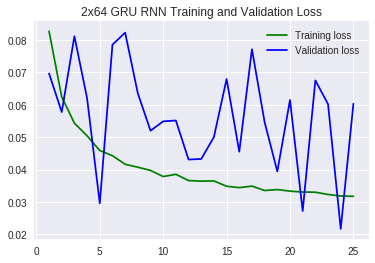

In [0]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.figure()
plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('2x64 GRU RNN Training and Validation Loss')
plt.legend()
plt.show()

In [0]:
# Temporary - to remove after training is completed
# Load previous history
with open('/content/gdrive/My Drive/python/base-4x128gru-1x32dense-dropout-history.pkl', 'rb') as infile:
    history = pickle.load(infile)
histories = []
histories.append(history)
# Load previous model
from keras.models import load_model
model = load_model('/content/gdrive/My Drive/python/base-4x128gru-1x32dense-dropout.h5')
model.summary()

In [36]:
t1 = datetime.datetime.now()
history = model.fit_generator(generator=gen_train, epochs=50,
                              validation_data=gen_val,
                              workers=2, use_multiprocessing=True, shuffle=True, verbose=2)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Epoch 1/50
 - 214s - loss: 0.0236 - mean_absolute_percentage_error: 15.7261 - val_loss: 0.0541 - val_mean_absolute_percentage_error: 21.0118
Epoch 2/50
 - 214s - loss: 0.0238 - mean_absolute_percentage_error: 15.8792 - val_loss: 0.0475 - val_mean_absolute_percentage_error: 20.3502
Epoch 3/50
 - 214s - loss: 0.0235 - mean_absolute_percentage_error: 15.5507 - val_loss: 0.0507 - val_mean_absolute_percentage_error: 20.2478
Epoch 4/50
 - 213s - loss: 0.0237 - mean_absolute_percentage_error: 15.7007 - val_loss: 0.0457 - val_mean_absolute_percentage_error: 19.6077
Epoch 5/50
 - 214s - loss: 0.0237 - mean_absolute_percentage_error: 15.9547 - val_loss: 0.0473 - val_mean_absolute_percentage_error: 20.2881
Epoch 6/50
 - 212s - loss: 0.0237 - mean_absolute_percentage_error: 16.2175 - val_loss: 0.0528 - val_mean_absolute_percentage_error: 23.9685
Epoch 7/50
 - 214s - loss: 0.0235 - mean_absolute_percentage_error: 16.1847 - val_loss: 0.0559 - val_mean_absolute_percentage_error: 26.1167
Epoch 8/50
 -

In [0]:
histories.append(history.history)

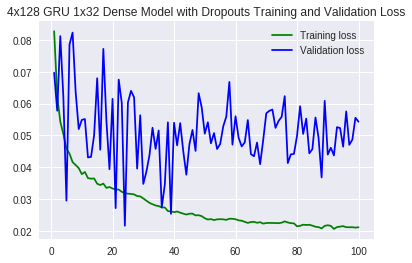

In [38]:
train_loss = []
val_loss = []
for history in histories:
    for a_loss in history['loss']:
        train_loss.append(a_loss)
    for a_loss in history['val_loss']:
        val_loss.append(a_loss)
epochs = range(1, len(train_loss) + 1)
plt.figure()
plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('4x128 GRU 1x32 Dense Model with Dropouts Training and Validation Loss')
plt.legend()
plt.show()

In [45]:
# print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
#                                                (min(val_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss[-20:]) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 2.200451
Validation MAE = 3.918404


In [46]:
gen_pred = mu.DataGenerator(as5_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                            batch_size=batch_size, step=step)
as5_train_preds = model.predict_generator(gen_pred, workers=1, use_multiprocessing=True)
as5_train_preds.shape

(29754, 1)

In [47]:
as5_train_preds_withnan = np.full((as5_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_data)):
    if as5_train_data[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds[j]
        j += 1
as5_train_preds_withnan.shape

(31616, 1)

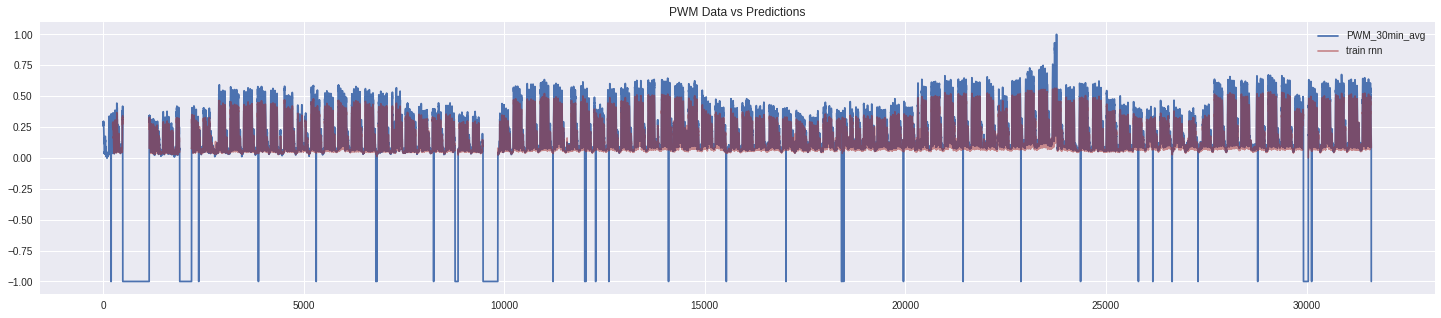

In [48]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(as5_train_data.shape[0]), as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

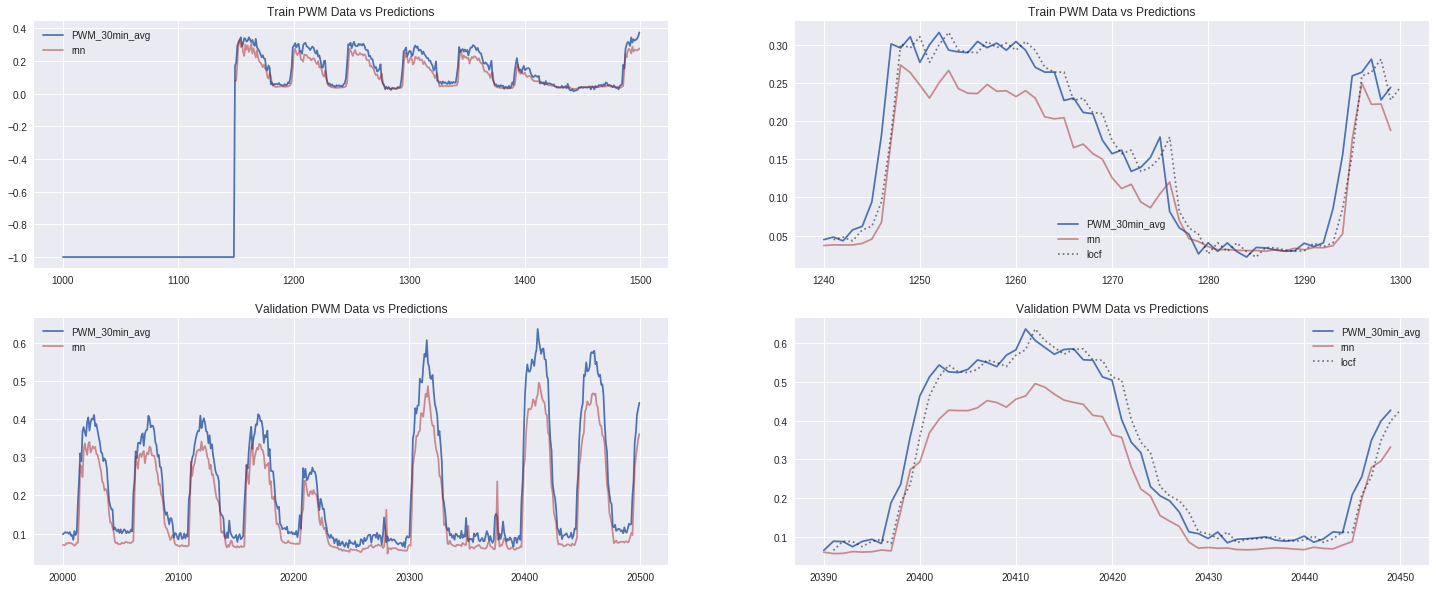

In [49]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(1000, 1500), as5_train_data[1000:1500, 0], label='PWM_30min_avg')
plt.plot(range(1000, 1500), as5_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1240, 1300), as5_train_data[1240:1300, 0], label='PWM_30min_avg')
plt.plot(range(1240, 1300), as5_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(1241, 1301), as5_train_data[1240:1300, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(20000, 20500), as5_train_data[20000:20500, 0], label='PWM_30min_avg')
plt.plot(range(20000, 20500), as5_train_preds_withnan[20000:20500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(20390, 20450), as5_train_data[20390:20450, 0], label='PWM_30min_avg')
plt.plot(range(20390, 20450), as5_train_preds_withnan[20390:20450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(20391, 20451), as5_train_data[20390:20450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [0]:
model.save('/content/gdrive/My Drive/python/base-4x128gru-1x32dense-dropout-0202.h5')

In [0]:
with open('/content/gdrive/My Drive/python/base-4x128gru-1x32dense-dropout-0202-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

## Base RNN (xxx nodes)

In [0]:
model = Sequential()
model.add(layers.GRU(64, return_sequences=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.GRU(64, return_sequences=True))
model.add(layers.GRU(64))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [0]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)

In [0]:
t1 = datetime.datetime.now()
history = model.fit_generator(generator=gen_train, epochs=120,
                              validation_data=gen_val,
                              workers=1, use_multiprocessing=True, shuffle=True, verbose=2)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

In [0]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.figure()
plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('3x64 GRU RNN Training and Validation Loss')
plt.legend()
plt.show()

In [0]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

In [0]:
as5_train_preds = model.predict_generator(gen_train, workers=1, use_multiprocessing=True)
as5_train_preds.shape

In [0]:
as5_train_preds_withnan = np.full((as5_train_split.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_split)):
    if as5_train_split[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds[j]
        j += 1
as5_train_preds_withnan.shape

In [0]:
as5_val_preds = model.predict_generator(gen_val, workers=1, use_multiprocessing=True)
as5_val_preds.shape

In [0]:
as5_val_preds_withnan = np.full((as5_val_split.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_val_split)):
    if as5_val_split[i, 0] > -1:
        as5_val_preds_withnan[i] = as5_val_preds[j]
        j += 1
as5_val_preds_withnan.shape

In [0]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(as5_train_split.shape[0]), as5_train_preds_withnan.flatten(), color='green', alpha=.5, label='train rnn')
plt.plot(range(20000, 20000 + as5_val_split.shape[0]), as5_val_preds_withnan.flatten(), color='green', alpha=.5, label='val rnn', linestyle=':')
plt.title('PWM Data vs Predictions')
plt.legend()

In [0]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(500), as5_train_data[:500, 0], label='PWM_30min_avg')
plt.plot(range(500), as5_train_preds_withnan[:500, :].flatten(), color='green', alpha=.5, label='rnn')
plt.title('PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1100, 1300), as5_train_data[1100:1300, 0], label='PWM_30min_avg')
plt.plot(range(1100, 1300), as5_train_preds_withnan[1100:1300].flatten(), color='green', alpha=.5, label='rnn')
plt.title('PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(1300, 1400), as5_train_data[1300:1400, 0], label='PWM_30min_avg')
plt.plot(range(1300, 1400), as5_train_preds_withnan[1300:1400].flatten(), color='green', alpha=.5, label='rnn')
plt.title('PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(1400, 1450), as5_train_data[1400:1450, 0], label='PWM_30min_avg')
plt.plot(range(1400, 1450), as5_train_preds_withnan[1400:1450].flatten(), color='green', alpha=.5, label='rnn')
plt.plot(range(1401, 1451), as5_train_data[1400:1450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('PWM Data vs Predictions')
plt.legend()

In [0]:
model.save('/content/gdrive/My Drive/python/base-xxx-nomask-val.h5')

In [0]:
with open('/content/gdrive/My Drive/python/base-xxx-nomask-val-history.pkl', 'wb') as outfile:
    pickle.dump(history.history, outfile)

## Base RNN (xxx)

In [0]:
model = Sequential()
model.add(layers.GRU(64, return_sequences=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.GRU(64, return_sequences=True))
model.add(layers.GRU(64, return_sequences=True))
model.add(layers.GRU(64))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [0]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)

In [0]:
gen_train.__len__()

In [0]:
gen_val.__len__()

In [0]:
t1 = datetime.datetime.now()
history = model.fit_generator(generator=gen_train, epochs=120,
                              validation_data=gen_val,
                              workers=1, use_multiprocessing=True, shuffle=True, verbose=2)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

In [0]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.figure()
plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('4x64 GRU RNN Training and Validation Loss')
plt.legend()
plt.show()

In [0]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

In [0]:
as5_train_preds = model.predict_generator(gen_train, workers=1, use_multiprocessing=True)
as5_train_preds.shape

In [0]:
as5_train_preds_withnan = np.full((as5_train_split.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_split)):
    if as5_train_split[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds[j]
        j += 1
as5_train_preds_withnan.shape

In [0]:
as5_val_preds = model.predict_generator(gen_val, workers=1, use_multiprocessing=True)
as5_val_preds.shape

In [0]:
as5_val_preds_withnan = np.full((as5_val_split.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_val_split)):
    if as5_val_split[i, 0] > -1:
        as5_val_preds_withnan[i] = as5_val_preds[j]
        j += 1
as5_val_preds_withnan.shape

In [0]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(as5_train_split.shape[0]), as5_train_preds_withnan.flatten(), color='green', alpha=.5, label='train rnn')
plt.plot(range(20000, 20000 + as5_val_split.shape[0]), as5_val_preds_withnan.flatten(), color='green', alpha=.5, label='val rnn', linestyle=':')
plt.title('PWM Data vs Predictions')
plt.legend()

In [0]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(500), as5_train_data[:500, 0], label='PWM_30min_avg')
plt.plot(range(500), as5_train_preds_withnan[:500, :].flatten(), color='green', alpha=.5, label='rnn')
plt.title('PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1100, 1300), as5_train_data[1100:1300, 0], label='PWM_30min_avg')
plt.plot(range(1100, 1300), as5_train_preds_withnan[1100:1300].flatten(), color='green', alpha=.5, label='rnn')
plt.title('PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(1300, 1400), as5_train_data[1300:1400, 0], label='PWM_30min_avg')
plt.plot(range(1300, 1400), as5_train_preds_withnan[1300:1400].flatten(), color='green', alpha=.5, label='rnn')
plt.title('PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(1400, 1450), as5_train_data[1400:1450, 0], label='PWM_30min_avg')
plt.plot(range(1400, 1450), as5_train_preds_withnan[1400:1450].flatten(), color='green', alpha=.5, label='rnn')
plt.plot(range(1401, 1451), as5_train_data[1400:1450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('PWM Data vs Predictions')
plt.legend()

In [0]:
model.save('/content/gdrive/My Drive/python/base-xxx-nomask-val.h5')

In [0]:
with open('/content/gdrive/My Drive/python/base-xxx-nomask-val-history.pkl', 'wb') as outfile:
    pickle.dump(history.history, outfile)